## This is the softmax workbook for ECE 239AS Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [5]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [7]:
from nndl import Softmax

In [8]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [9]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [10]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this value make sense?

## Answer:

Because we have 10 classes for figures in CIFAR-10. And the probability of each class to be chosen is 1/10. If we use the softmax loss function, the result is -log(1/10)=2.3

#### Softmax gradient

In [11]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: -0.498003 analytic: -0.498003, relative error: 1.615293e-08
numerical: 0.702353 analytic: 0.702353, relative error: 1.432382e-08
numerical: 0.507685 analytic: 0.507685, relative error: 4.065648e-08
numerical: 1.742536 analytic: 1.742536, relative error: 4.098931e-09
numerical: 0.321761 analytic: 0.321760, relative error: 2.697055e-07
numerical: 0.055165 analytic: 0.055165, relative error: 8.711104e-07
numerical: 0.028269 analytic: 0.028269, relative error: 1.124172e-06
numerical: -0.051942 analytic: -0.051942, relative error: 4.862615e-07
numerical: -0.043374 analytic: -0.043374, relative error: 6.897428e-07
numerical: -2.789682 analytic: -2.789682, relative error: 1.627961e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [12]:
import time

In [15]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.318747691803609 / 299.30064761177914 computed in 0.1875443458557129s
Vectorized loss / grad: 2.31874769180361 / 299.30064761177914 computed in 0.2982981204986572s
difference in loss / grad: -8.881784197001252e-16 /2.4504644929788423e-13 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The methods of gradient descent we use for SVM and softmax are the same. We use stochasted gradient descent for both algorithm.

iteration 0 / 1500: loss 2.3867288972274294
iteration 100 / 1500: loss 2.0412553498089605
iteration 200 / 1500: loss 2.020767240354473
iteration 300 / 1500: loss 1.9460756828763517
iteration 400 / 1500: loss 1.8694006006370403
iteration 500 / 1500: loss 1.9749192473297836
iteration 600 / 1500: loss 1.9924347024831224
iteration 700 / 1500: loss 1.8626090889442464
iteration 800 / 1500: loss 1.820056107717809
iteration 900 / 1500: loss 1.7955604704297725
iteration 1000 / 1500: loss 1.7564781944521946
iteration 1100 / 1500: loss 1.794684783540606
iteration 1200 / 1500: loss 1.8219107994426305
iteration 1300 / 1500: loss 1.8932750881137355
iteration 1400 / 1500: loss 1.795530011278038
That took 14.285821676254272s


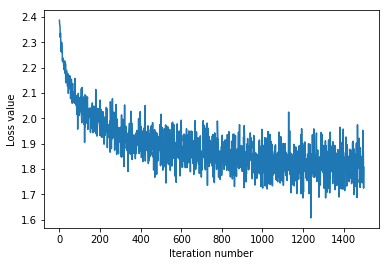

In [17]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [18]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3809387755102041
validation accuracy: 0.392


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [19]:
np.finfo(float).eps

2.220446049250313e-16

In [24]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rate_list = [5e-8,1e-7,5e-7,1e-6,1e-5,5e-4]
accuracy_list= []
for learning_rate in learning_rate_list:
    softmax.train(X_train,y_train,learning_rate=learning_rate, num_iters=1000,
            batch_size=200, verbose=False)
    y_val_pred = softmax.predict(X_val)
    accuracy = np.mean(np.equal(y_val_pred,y_val))
    print("the accuracy for softmax when learning rate = ",learning_rate," is ",accuracy)
    accuracy_list.append(accuracy)
best_loc = np.argmax(accuracy_list)
best_learning_rate = learning_rate_list[best_loc]
best_accuracy = accuracy_list[best_loc]
print("the best learning rate is ",best_learning_rate,
      " and the corresponding accuracy is ",best_accuracy)
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #


the accuracy for softmax when learning rate =  5e-08  is  0.355
the accuracy for softmax when learning rate =  1e-07  is  0.372
the accuracy for softmax when learning rate =  5e-07  is  0.407
the accuracy for softmax when learning rate =  1e-06  is  0.399
the accuracy for softmax when learning rate =  1e-05  is  0.325


C:\Users\ninga\OneDrive\Desktop\ECE239AS\HW2_code\code\nndl\softmax.py:149: RuntimeWarning: invalid value encountered in true_divide
  grad_score_part = score_exp_matrix / np.sum(score_exp_matrix, axis=0)


the accuracy for softmax when learning rate =  0.0005  is  0.087
the best learning rate is  5e-07  and the corresponding accuracy is  0.407


# The part below is softmax.py

In [ ]:
import numpy as np

class Softmax(object):

  def __init__(self, dims=[10, 3073]):
    self.init_weights(dims=dims)

  def init_weights(self, dims):
    """
	Initializes the weight matrix of the Softmax classifier.  
	Note that it has shape (C, D) where C is the number of 
	classes and D is the feature size.
	"""
    self.W = np.random.normal(size=dims) * 0.0001

  def loss(self, X, y):
    """
    Calculates the softmax loss.
  
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
  
    Inputs:
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
  
    Returns a tuple of:
    - loss as single float
    """

    # Initialize the loss to zero.
    loss = 0.0

    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the normalized softmax loss.  Store it as the variable loss.
    #   (That is, calculate the sum of the losses of all the training 
    #   set margins, and then normalize the loss by the number of 
    #   training examples.)
    # ================================================================ #
    num_train = X.shape[0]
    num_class = self.W.shape[0]
    
    for i in range(num_train):
        score_i = np.dot(self.W,X[i].T)
        score_correctclass = score_i[y[i]]
        score_exp = np.exp(score_i)
        sum_score = np.sum(score_exp)
        loss += np.log(sum_score)-score_correctclass 
    loss /= num_train
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss

  def loss_and_grad(self, X, y):
    """
	Same as self.loss(X, y), except that it also returns the gradient.

	Output: grad -- a matrix of the same dimensions as W containing 
		the gradient of the loss with respect to W.
	"""

    # Initialize the loss and gradient to zero.
    loss = 0.0
    grad = np.zeros_like(self.W)
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and the gradient. Store the gradient
    #   as the variable grad.
    # ================================================================ #
    num_train = X.shape[0]
    num_class = self.W.shape[0]
    
    for i in range(num_train):
        score_i = np.dot(self.W,X[i].T)
        score_correctclass = score_i[y[i]]
        score_exp = np.exp(score_i)
        sum_score = np.sum(score_exp)
        loss += np.log(sum_score) - score_correctclass
        for j in range(num_class):
            if y[i]==j:
                grad[j,:] += np.exp(score_i[j])*X[i]/sum_score - X[i]
            else:
                grad[j,:] += np.exp(score_i[j])*X[i]/sum_score
        
    loss /= num_train
    grad /= num_train
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def grad_check_sparse(self, X, y, your_grad, num_checks=10, h=1e-5):
    """
    sample a few random elements and only return numerical
    in these dimensions.
    """
  
    for i in np.arange(num_checks):
      ix = tuple([np.random.randint(m) for m in self.W.shape])
  
      oldval = self.W[ix]
      self.W[ix] = oldval + h # increment by h
      fxph = self.loss(X, y)
      self.W[ix] = oldval - h # decrement by h
      fxmh = self.loss(X,y) # evaluate f(x - h)
      self.W[ix] = oldval # reset
  
      grad_numerical = (fxph - fxmh) / (2 * h)
      grad_analytic = your_grad[ix]
      rel_error = abs(grad_numerical - grad_analytic) / (abs(grad_numerical) + abs(grad_analytic))
      print('numerical: %f analytic: %f, relative error: %e' % (grad_numerical, grad_analytic, rel_error))

  def fast_loss_and_grad(self, X, y):
    """
    A vectorized implementation of loss_and_grad. It shares the same
	inputs and ouptuts as loss_and_grad.
    """
    loss = 0.0
    grad = np.zeros(self.W.shape) # initialize the gradient as zero
  
    # ================================================================ #
    # YOUR CODE HERE:
    #   Calculate the softmax loss and gradient WITHOUT any for loops.
    # ================================================================ #
    num_train = X.shape[0]
    num_class = self.W.shape[0]
    
    score_matrix = np.dot(self.W,X.T)
    
    indicator_matrix = np.zeros_like(score_matrix)
    indicator_matrix[y,np.arange(num_train)] = 1
    score_correctclass_matrix = np.multiply(score_matrix,indicator_matrix)
    score_correctclass_vector = np.sum(score_correctclass_matrix, axis=0)
    
    score_exp_matrix = np.exp(score_matrix)
    loss_matrix = np.log(np.sum(score_exp_matrix,axis=0)) - score_correctclass_vector
    loss = np.sum(loss_matrix)/num_train
    
    grad_score_part = score_exp_matrix / np.sum(score_exp_matrix, axis=0)
    grad = np.dot(grad_score_part,X) - np.dot(indicator_matrix,X)
    grad /= num_train
    
    pass
    
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return loss, grad

  def train(self, X, y, learning_rate=1e-3, num_iters=100,
            batch_size=200, verbose=False):
    """
    Train this linear classifier using stochastic gradient descent.

    Inputs:
    - X: A numpy array of shape (N, D) containing training data; there are N
      training samples each of dimension D.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c
      means that X[i] has label 0 <= c < C for C classes.
    - learning_rate: (float) learning rate for optimization.
    - num_iters: (integer) number of steps to take when optimizing
    - batch_size: (integer) number of training examples to use at each step.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
    A list containing the value of the loss function at each training iteration.
    """
    num_train, dim = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    self.init_weights(dims=[np.max(y) + 1, X.shape[1]])	# initializes the weights of self.W

    # Run stochastic gradient descent to optimize W
    loss_history = []

    for it in np.arange(num_iters):
        X_batch = None
        y_batch = None

      # ================================================================ #
      # YOUR CODE HERE:
      #   Sample batch_size elements from the training data for use in 
      #      gradient descent.  After sampling,
      #     - X_batch should have shape: (dim, batch_size)
      #     - y_batch should have shape: (batch_size,)
      #   The indices should be randomly generated to reduce correlations
      #   in the dataset.  Use np.random.choice.  It's okay to sample with
      #   replacement.
      # ================================================================ #
        idx = np.random.choice(num_train,batch_size)
        X_batch = X[idx]
        y_batch = y[idx]
        pass
      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

      # evaluate loss and gradient
        loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
        loss_history.append(loss)

      # ================================================================ #
      # YOUR CODE HERE:
      #   Update the parameters, self.W, with a gradient step 
      # ================================================================ #
        self.W -= learning_rate * grad
        pass

      # ================================================================ #
      # END YOUR CODE HERE
      # ================================================================ #

        if verbose and it % 100 == 0:
            print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    return loss_history

  def predict(self, X):
    """
    Inputs:
    - X: N x D array of training data. Each row is a D-dimensional point.

    Returns:
    - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
      array of length N, and each element is an integer giving the predicted
      class.
    """
    y_pred = np.zeros(X.shape[0])
    # ================================================================ #
    # YOUR CODE HERE:
    #   Predict the labels given the training data.
    # ================================================================ #
    score = np.dot(self.W,X.T)
    y_pred = np.argmax(score,axis=0)
    pass
    # ================================================================ #
    # END YOUR CODE HERE
    # ================================================================ #

    return y_pred